In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import combinations
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

# Cointegration and Correlation Analysis

In [2]:
# Function to fetch stock data using yfinance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    # return (stock_data['Close'].pct_change().dropna() + 1).cumprod() - 1
    return stock_data['Close']

# Define the fixed stock and a list of different stocks to pair with

"""medicine stocks:"""
tickers = [
    '2359.HK',
    '2269.HK',
    '6160.HK',
    # '9926.HK',
    # '2268.HK',
]  # Add more stocks as needed
name_mapping = {
    '2359.HK': 'ymhd',
    '2269.HK': 'ymsm',
    '6160.HK': 'flbtsm',
    '9926.HK': 'hfsm',
    '2268.HK': 'ymhl',
}

# """bank stocks:"""
# tickers = [
#     '1398.HK',
#     '0939.HK',
#     '1288.HK',
#     '3988.HK',
#     '3968.HK',
#     '2388.HK',
# ]  # Add more stocks as needed
# name_mapping = {
#     '1398.HK': 'icbc',
#     '0939.HK': 'ccb',
#     '1288.HK': 'abc',
#     '3988.HK': 'boc',
#     '3968.HK': 'cmb',
#     '2388.HK': 'bochk',
# }

[*********************100%***********************]  3 of 3 completed


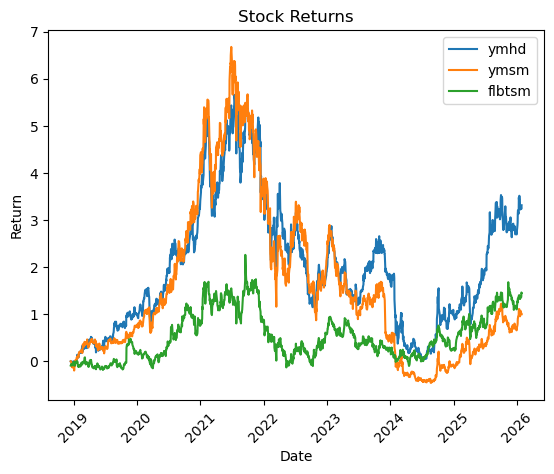

In [3]:
# Pairwise cointegration and correlation matrix for all selected tickers
results = []
start_date = "2010-02-01"
end_date = "2026-01-30"

# Fetch price data for all tickers
price_data = fetch_stock_data(tickers, start_date, end_date)
price_data = price_data.fillna(method='ffill').dropna()
returns = (price_data.pct_change().dropna() + 1).cumprod() - 1

# Use the same series type as before (cumulative returns) for comparison
series = returns

for s1, s2 in combinations(tickers, 2):
    x = series[s1].dropna()
    y = series[s2].dropna()
    # align
    common_index = x.index.intersection(y.index)
    x = x.loc[common_index]
    y = y.loc[common_index]
    if len(common_index) < 10:
        # insufficient data
        continue

    # Regression-based residual ADF
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    resid = model.resid
    try:
        adf_p = adfuller(resid)[1]
    except Exception:
        adf_p = np.nan

    # Cointegration test (statsmodels.coint) p-value
    try:
        coint_p = coint(x, y)[1]
    except Exception:
        coint_p = np.nan

    # Correlation (on the same series)
    corr = x.corr(y)

    results.append({
        'Stock1': s1,
        'Stock2': s2,
        'Cointegration_pvalue': coint_p,
        'ADF_resid_pvalue': adf_p,
        'Correlation': corr
    })

# Tidy results dataframe for pair list
results_df = pd.DataFrame(results)

# Build symmetric matrices (tickers as rows/cols)
cointegration_matrix = pd.DataFrame(np.nan, index=tickers, columns=tickers)
correlation_matrix = pd.DataFrame(np.nan, index=tickers, columns=tickers)

for _, row in results_df.iterrows():
    s1 = row['Stock1']
    s2 = row['Stock2']
    cointegration_matrix.loc[s1, s2] = row['Cointegration_pvalue']
    cointegration_matrix.loc[s2, s1] = row['Cointegration_pvalue']
    correlation_matrix.loc[s1, s2] = row['Correlation']
    correlation_matrix.loc[s2, s1] = row['Correlation']

# Optionally map tickers to names for nicer display (preserve tickers if missing)
named_index = [name_mapping.get(t, t) for t in tickers]
cointegration_matrix_named = cointegration_matrix.copy()
cointegration_matrix_named.index = named_index
cointegration_matrix_named.columns = named_index
correlation_matrix_named = correlation_matrix.copy()
correlation_matrix_named.index = named_index
correlation_matrix_named.columns = named_index

for stock in tickers:
    paired_stock_data = returns[stock]
    plt.plot(paired_stock_data, label=name_mapping[stock])

plt.title('Stock Returns')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Return')
plt.legend()
plt.show()

In [4]:
cointegration_matrix_named

,ymhd,ymsm,flbtsm
ymhd,NaN,0.760006,0.140945
ymsm,0.760006,NaN,0.848591
flbtsm,0.140945,0.848591,NaN


In [5]:
correlation_matrix_named

,ymhd,ymsm,flbtsm
ymhd,NaN,0.896642,0.823074
ymsm,0.896642,NaN,0.641959
flbtsm,0.823074,0.641959,NaN


# Backtest the Strategy

### Choose Pair Stock and Set Lot Size (for HK stocks)

In [6]:
stock1_data = price_data['2269.HK']
stock2_data = price_data["6160.HK"]
stock1_lot = 500
stock2_lot = 100

In [ ]:
# # Scale the data based on shares per hand (deprecated)
# stock1_data *= stock1_lot
# stock2_data *= stock2_lot

# Calculate the spread between the two stocks
spread = stock1_data - stock2_data

# Perform Augmented Dickey-Fuller (ADF) test to analyze mean-reverting tendencies (stationarity) of the spread
adf_test = adfuller(spread.dropna(), maxlag=1)
adf_statistic = adf_test[0]
adf_p_value = adf_test[1]

# Display ADF test results
print("ADF Statistic:", adf_statistic)
print("ADF p-value:", adf_p_value)

ADF Statistic: -2.049306719091954
ADF p-value: 0.2653807063787478


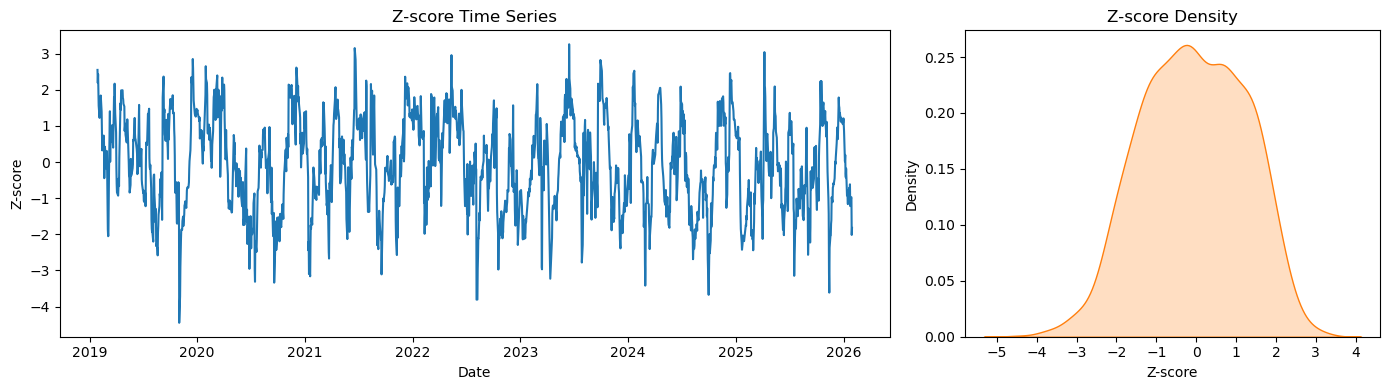

In [8]:
# Z-score parameters
window = 30

# Calculate z-score of the spread based on a rolling 3-month window
spread_mean = spread.rolling(window=window).mean()
spread_std = spread.rolling(window=window).std()
z_score = (spread - spread_mean) / spread_std

# Plot: left = time series, right = KDE density
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={'width_ratios':[2,1]})

# Time series panel
ax1.plot(z_score.index, z_score, color='C0')
ax1.set_title('Z-score Time Series')
ax1.set_xlabel('Date')
ax1.set_ylabel('Z-score')

# KDE density panel
sns.kdeplot(z_score.dropna(), fill=True, ax=ax2, bw_method='scott', color='C1')
ax2.set_title('Z-score Density')
ax2.set_xlabel('Z-score')
plt.xticks(np.arange(-5, 5, 1))
plt.tight_layout()
plt.show()

### Tunable Parameters

In [9]:
# Risk params: leverage and maintenance margin for margin call
leverage = 1
maintenance_margin_pct = 0.3
borrowing_pct_cost_annual = 0.068
short_sell_pct_cost_annual = 0.0112

# Define entry and exit thresholds
entry_threshold = 2.3
exit_threshold = 1
stop_loss_pct = 0.01 * leverage + (borrowing_pct_cost_annual+short_sell_pct_cost_annual) / 10

# Define initial capital
initial_capital = 100000

# Sharpe ratio parameters
risk_free_rate_annual = 0.03665

### Run Backtest

Completed trades: 52
Stop losses triggered: 29
Margin calls: 0
Total return: 12.28%
Annualized return: 1.68%
Sharpe Ratio (annualized): -0.0469


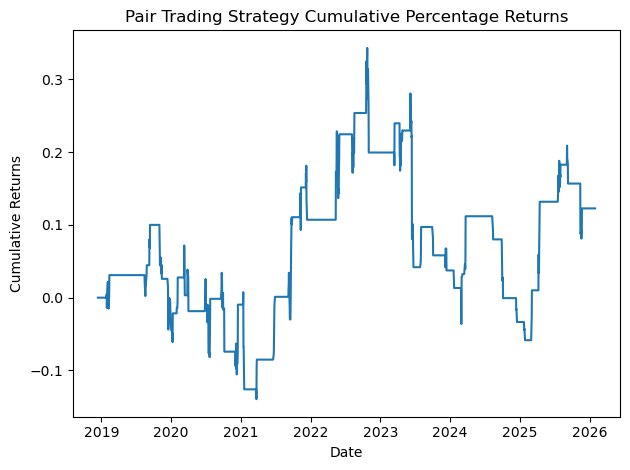

In [10]:
current_capital = initial_capital

# Generate signals
signals = np.where(z_score > entry_threshold, -1, np.where(z_score < -entry_threshold, 1, 0))

# Backtest the pair trading strategy
position = 0
transaction_cost = 0
pct_returns = []
completed_trades = 0
margin_call_count = 0
t = 0
a , b = 0, 0
current_trade_pl = 0
stop_loss_count = 0
cooldown_period = 0

# Trade logging
trades_log = []
entry_info = None

for i in range(1, len(signals)):
    old_position = position

    # Compute daily realized P/L based on previous position
    if old_position == 1:
        r = (a * (stock1_data.iloc[i] - stock1_data.iloc[i-1]) - b * (stock2_data.iloc[i] - stock2_data.iloc[i-1]))
    elif old_position == -1:
        r = (b * (stock2_data.iloc[i] - stock2_data.iloc[i-1]) - a * (stock1_data.iloc[i] - stock1_data.iloc[i-1]))
    else:
        r = 0

    # Daily financing costs (borrow interest + short borrow fee) while position is open
    financing_cost = 0.0
    if position != 0:
        # Current prices
        p1 = stock1_data.iloc[i]
        p2 = stock2_data.iloc[i]
        # Notional of short leg depends on position sign
        if position == 1:
            notional_short = b * p2
        else:  # position == -1
            notional_short = a * p1
        notional_short = max(0.0, notional_short)

        # Borrowed cash amount = market notional of the position - equity used at entry
        current_notional = (abs(a * p1) + abs(b * p2))
        borrowed_cash = max(0.0, current_notional - current_capital - r)

        # Daily interest/fees (assuming 252 trading days)
        daily_borrow_interest = borrowed_cash * (borrowing_pct_cost_annual / 252)
        daily_short_fee = notional_short * (short_sell_pct_cost_annual / 252)

        financing_cost = -(daily_borrow_interest + daily_short_fee)

    # Apply P/L and financing costs
    current_trade_pl += r + financing_cost
    # Include transaction_cost (entry commission) on the day it was set; financing_cost applied daily
    daily_total = r + financing_cost + transaction_cost
    pct_returns.append(daily_total / current_capital if current_capital != 0 else 0)
    current_capital += daily_total

    # Reset transaction cost after it's applied
    transaction_cost = 0

    # if cooldown_period > 0:
    #     cooldown_period -= 1
    #     continue

    # Entry signals
    if signals[i] == 1 and position == 0:
        position = 1
        pr = (stock1_data.iloc[i] * stock1_lot) / (stock2_data.iloc[i] * stock2_lot)
    elif signals[i] == -1 and position == 0:
        position = -1
        pr = (stock1_data.iloc[i] * stock1_lot) / (stock2_data.iloc[i] * stock2_lot)

    # Exit / stop loss
    elif current_trade_pl / current_capital <= -stop_loss_pct or (signals[i] == 0 and abs(z_score.iloc[i]) < exit_threshold and position != 0):
        if current_trade_pl / current_capital <= -stop_loss_pct:
            cooldown_period = 10
            stop_loss_count += 1
        # log exit if trade was open
        if entry_info is not None:
            entry_info.update({
                'exit_index': i,
                'exit_date': stock1_data.index[i],
                'pnl': current_trade_pl,
            })
            trades_log.append(entry_info)
        # Exit the position
        position = 0
        completed_trades += 1
        current_trade_pl = 0
        entry_info = None

    # On entry, compute contract size using leverage and record entry info
    if old_position == 0 and position != 0:
        if pr < 1:
            a = 1/pr
            b = 1
        else:
            a = 1
            b = pr
        cost_per_unit = (a * stock1_data.iloc[i] + b * stock2_data.iloc[i])
        # Allow notional up to current_capital * leverage
        if cost_per_unit > 0:
            multiple = int((current_capital * leverage) // cost_per_unit)
        else:
            multiple = 0
        # commission/entry cost
        a = int(a * multiple)
        b = int(b * multiple)
        capital_used = a * stock1_data.iloc[i] + b * stock2_data.iloc[i]
        transaction_cost = - capital_used * 0.1105/100

        # record entry
        entry_info = {
            'entry_index': i,
            'entry_date': stock1_data.index[i],
            'position': position,
            'a': a,
            'b': b,
            'entry_capital': current_capital,
            'capital_used': capital_used,
            'entry_cost': transaction_cost
        }

    # Margin check while position is open: compute gross position market value
    if position != 0:
        pos_market_value = (abs(a * stock1_data.iloc[i]) + abs(b * stock2_data.iloc[i]))
        # Avoid division by zero
        if pos_market_value > 0:
            margin_ratio = current_capital / pos_market_value
        else:
            margin_ratio = np.inf
        # Trigger margin call (forced liquidation) if maintenance margin breached
        if margin_ratio < maintenance_margin_pct:
            print(f"Margin call triggered at index {i}, date {stock1_data.index[i]}, margin_ratio={margin_ratio:.4f}, capital={current_capital:.2f}")
            # log exit due to margin call
            if entry_info is not None:
                entry_info.update({
                    'exit_index': i,
                    'exit_date': stock1_data.index[i],
                    'pnl': current_trade_pl,
                    'exit_reason': 'margin_call'
                })
                trades_log.append(entry_info)
            # force exit: realize liquidation (already included in r), then reset position
            position = 0
            completed_trades += 1
            margin_call_count += 1
            current_trade_pl = 0
            entry_info = None

# End loop
print(f"Completed trades: {completed_trades}")
print(f"Stop losses triggered: {stop_loss_count}")
print(f"Margin calls: {margin_call_count}")
print(f"Total return: {(current_capital - initial_capital) / initial_capital:.2%}")
print(f"Annualized return: {((current_capital / initial_capital) ** (252 / len(pct_returns)) - 1) * 100:.2f}%")

# Calculate cumulative returns
cumulative_pct_returns = np.cumprod(1 + np.array(pct_returns)) - 1 if len(pct_returns) > 0 else np.array([])
fig, ax = plt.subplots(1, 1)
ax.plot(stock1_data.index[1:1+len(cumulative_pct_returns)], cumulative_pct_returns)
ax.set_title('Pair Trading Strategy Cumulative Percentage Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

# --- Sharpe ratio calculation (annualized) ---
daily_ex_returns = np.array(pct_returns) - risk_free_rate_annual/252
mean_daily = np.nanmean(daily_ex_returns) if len(daily_ex_returns) > 0 else 0.0
std_daily = np.nanstd(daily_ex_returns) if len(daily_ex_returns) > 0 else 0.0
annual_factor = 252
if std_daily == 0 or np.isnan(std_daily):
    sharpe_ratio = np.nan
else:
    sharpe_ratio = (mean_daily / std_daily) * np.sqrt(annual_factor)
print(f"Sharpe Ratio (annualized): {sharpe_ratio:.4f}")

plt.tight_layout()
plt.show()
# Implement risk management and further refine the strategy as needed

In [11]:
# Save/print trade log
trades_df = pd.DataFrame(trades_log)
if not trades_df.empty:
    display(trades_df)
    # optional: save to CSV
    # trades_df.to_csv('trade_log.csv', index=False)

,entry_index,entry_date,position,a,b,entry_capital,capital_used,entry_cost,exit_index,exit_date,pnl
0,29,2019-01-28,-1,805,1102,100000.000000,99919.603977,-110.411162,37,2019-02-12,3211.716812
1,162,2019-08-15,1,652,1022,103101.305649,102966.229385,-113.777683,164,2019-08-19,-2746.110246
2,165,2019-08-20,1,603,928,100241.417720,100017.402449,-110.519230,170,2019-08-27,4331.477150
3,179,2019-09-09,-1,632,1163,104462.375640,104393.469894,-115.354784,183,2019-09-13,5661.936721
4,216,2019-11-01,1,636,833,110008.957577,109957.399353,-121.502926,217,2019-11-04,-5285.373497
5,218,2019-11-05,1,607,756,104602.081154,104350.782793,-115.307615,225,2019-11-14,-1894.138432
6,245,2019-12-12,-1,554,796,102592.635107,102403.630341,-113.156012,248,2019-12-17,-6857.600501
7,249,2019-12-18,-1,479,805,95621.878594,95444.786034,-105.466489,263,2020-01-10,2329.224222
8,275,2020-01-30,-1,495,901,97845.636327,97752.401878,-108.016404,279,2020-02-05,5044.121990
9,302,2020-03-09,-1,438,965,102781.741914,102499.099777,-113.261505,306,2020-03-13,-2335.390484


# Alpha Analysis

In [12]:
factor_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv', skiprows=4, header=0)
mom_df = pd.read_csv('F-F_Momentum_Factor_daily.csv', skiprows=13, header=0)

# parse Date (files use YYYYMMDD) and coerce invalid/footer rows
factor_df['Date'] = pd.to_datetime(factor_df['Date'], format='%Y%m%d', errors='coerce')
mom_df['Date'] = pd.to_datetime(mom_df['Date'], format='%Y%m%d', errors='coerce')

# # drop rows with invalid dates (footers)
# factor_df = factor_df.dropna(subset=['Date']).copy()
# mom_df = mom_df.dropna(subset=['Date']).copy()

# remove any unnamed/footer columns from momentum file
mom_df = mom_df.loc[:, ~mom_df.columns.str.contains('^Unnamed')]

# merge, set Date as index and align to price_data index
carhart_df = pd.merge(factor_df, mom_df, on='Date', how='inner')
carhart_df = carhart_df.set_index('Date').sort_index()
carhart_df = carhart_df.loc[carhart_df.index.isin(price_data.index)]

# ensure numeric and convert from percent to decimal
carhart_df = carhart_df.apply(pd.to_numeric, errors='coerce') / 100
carhart_df = carhart_df[1:]
carhart_df

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
2018-12-14,-0.0189,-0.0006,0.0049,0.0001,-0.0053
2018-12-17,-0.0213,-0.0025,0.0108,0.0001,-0.0099
2018-12-18,-0.0003,0.0002,-0.0060,0.0001,0.0028
2018-12-19,-0.0158,-0.0060,0.0002,0.0001,0.0065
2018-12-20,-0.0162,-0.0028,0.0097,0.0001,-0.0046
...,...,...,...,...,...
2025-12-23,0.0032,-0.0094,-0.0020,0.0002,0.0082
2025-12-24,0.0029,0.0003,0.0001,0.0002,-0.0022
2025-12-29,-0.0041,-0.0018,0.0007,0.0002,-0.0016


In [13]:
# convert pct_returns (list) to a pandas Series with proper dates, then align with Carhart factors
strategy_returns = pd.Series(pct_returns, index=stock1_data.index[1:1+len(pct_returns)])

# align indices
common_idx = strategy_returns.index.intersection(carhart_df.index)

y = strategy_returns.loc[common_idx] - carhart_df.loc[common_idx, 'RF']
X = sm.add_constant(carhart_df.loc[common_idx, ['Mkt-RF', 'SMB', 'HML', 'Mom']])

reg = sm.OLS(y, X).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7319
Date:                Sat, 07 Feb 2026   Prob (F-statistic):              0.570
Time:                        00:03:24   Log-Likelihood:                 5371.8
No. Observations:                1685   AIC:                        -1.073e+04
Df Residuals:                    1680   BIC:                        -1.071e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.991e-06      0.000      0.016      0.9